# RANDOM FOREST REVISITED

# LLIBRERIES

Visualize trees libraries

In [1]:
!apt-get install graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


UCI MLR Respository

In [2]:
pip install ucimlrepo

LightGBM and Xgboost Libraries

In [3]:
!pip install lightgbm xgboost

Imports for other libraries

In [4]:

import numpy as np
import pandas as pd
import random
import pprint
import time
import os
from collections import Counter
from graphviz import Digraph
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# DECISION TREE

In [5]:

class DecisionTree:
    """Implementacio de un arbre de decisio CART personalitzat que gestiona NUllS.

    Parametres
    ----------
    max_depth : int o None
        Profunditat màxima de l’arbre. Si és None, els nodes s’expandeixen fins que totes les fulles siguin pures
        o continguin menys de `min_samples_split` mostres.
    min_samples_split : int, per defecte 2
        Nombre mínim de mostres requerit per dividir un node intern.
    feature_subset : int o None
        Nombre de característiques a considerar a l’hora de buscar el millor punt de divisió.
        Si és None, s’utilitzen totes les característiques.
    """
        #Constructor de l'arbre
    def __init__(self, max_depth=None, min_samples_split=2, feature_subset=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.feature_subset = feature_subset
        self.tree = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        """Entrena l'arbre de decisio"""
        self.n_features = self.feature_subset or X.shape[1] # Guarda num features per split
        self.y_train = y #Guarda y
        self.tree = self._build_tree(X, y, depth=0) #inici construccio arbre

    def _gini(self, y: pd.Series):
        """Calcula l'impuresa de Gini"""
        counts = y.value_counts().values
        probs = counts / counts.sum()  # Normalitzem per obtenir probabilitats
        return 1 - np.sum(probs ** 2)  # Retorna l'impuresa del node

    def _best_split(self, X: pd.DataFrame, y: pd.Series):
        """Troba la millor divisió segons el gain amb l'índex de Gini, gestionant valors nuls i categòriques."""
        best_gain = 0
        best_feature = None
        best_threshold = None
        best_is_categorical = False

        current_gini = self._gini(y)  # Gini actual del node
        feature_idxs = random.sample(range(X.shape[1]), self.n_features)  # Selecció aleatòria de característiques

        for feature in feature_idxs:
            col = X.iloc[:, feature]  # Agafa la columna corresponent a feature del conjunt

            # Detectem si és categòrica
            is_categorical = col.dtype.name == "category" or col.dtype == object

            if is_categorical:
                #CATEGÒRIQUES
                values = col.dropna().unique()  # Guardem valors unics (sense NaNs)
                for val in values:
                    if pd.isna(val):  # Evitem usar NaN per fer split
                        continue
                    #Pertinença/grups per categòriques i nulls apart
                    left_mask = col == val
                    right_mask = col != val
                    null_mask = col.isna()

                    #Si hi ha una branca pel llindar, salta al seguent
                    if left_mask.sum() == 0 or right_mask.sum() == 0:
                        continue

                    #Generem llistes de valors segons les mascares booleanes
                    y_left, y_right, y_null = y[left_mask], y[right_mask], y[null_mask]
                    #Calcul del Gini amb la feature i llindar actual de cada subconjunt
                    gini_left, gini_right, gini_null = self._gini(y_left), self._gini(y_right), self._gini(y_null)
                    #Calcul de l'imupresa mitjana ponderada segons la dimensio dels subconnjunts anteriors
                    weighted_gini = (
                        (len(y_left) * gini_left + len(y_right) * gini_right + len(y_null) * gini_null) / len(y)
                    )
                    #Calcul del gain global, per saber quant ha millorat el node
                    gain = current_gini - weighted_gini

                    #Historial que es sobreescriu per quedarnos al final amb el milllor gain i els parametres relacionats
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_threshold = val
                        best_is_categorical = True

            else:
                # NUMÈRIQUES
                thresholds = col.dropna().unique()  # Elimina NaNs per trobar valors reals
                for threshold in thresholds:
                    if pd.isna(threshold):  # Evitem thresholds nuls
                        continue

                    left_mask = col <= threshold
                    right_mask = col > threshold
                    null_mask = col.isna()

                    if left_mask.sum() == 0 or right_mask.sum() == 0:
                        continue

                    y_left, y_right, y_null = y[left_mask], y[right_mask], y[null_mask]
                    gini_left, gini_right, gini_null = self._gini(y_left), self._gini(y_right), self._gini(y_null)
                    weighted_gini = (
                        (len(y_left) * gini_left + len(y_right) * gini_right + len(y_null) * gini_null) / len(y)
                    )
                    gain = current_gini - weighted_gini

                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_threshold = threshold
                        best_is_categorical = False

        # Si no es troba un gain millor a 0 o threshold és null, retorna None per indicar que no es pot construir més ---> (fulla)
        if best_feature is None or pd.isna(best_threshold):
            return None, None, None
        else:
            return best_feature, best_threshold, best_is_categorical

    def _split_dataset(self, X: pd.DataFrame, y: pd.Series, feature, threshold, is_categorical):
        """Divideix el dataset en tres subconjunts: esquerra, dreta i valors nuls.
        Per categòriques: esquerra = igualtat, dreta = diferent. Per numèriques: esquerra = <= threshold, dreta = > threshold.
        """
        col = X.iloc[:, feature] #Accedim a la columna feature

        if is_categorical:
            left_mask = col == threshold     # Pertinença (categoria igual)
            right_mask = col != threshold    # Categoria diferent
        else:
            left_mask = col <= threshold     # Numèrica segons threshold
            right_mask = col > threshold

        null_mask = col.isna()

        return (
            X[left_mask], y[left_mask],
            X[right_mask], y[right_mask],
            X[null_mask], y[null_mask]
        )

    def _build_tree(self, X: pd.DataFrame, y: pd.Series, depth):
        """Construcció recursiva de l'arbre, incloent una branca per valors nuls."""

        #Si s'ha de crear fulla es retorna la classe majoritaria
        #Raons: max depth, poques mostres per dividir o totes les clases son la mateixa
        if depth == self.max_depth or len(X) < self.min_samples_split or self._gini(y) == 0:
            return self._most_common_class(y)

        #Es busca el seguent millor split
        best_feature, best_threshold, is_categorical = self._best_split(X, y)

        #Si no s'ha trobat un split millor, retornem classe majoritaria, es crea fulla
        if best_feature is None or pd.isna(best_threshold):
            return self._most_common_class(y)

        #Es divideix el dataset segons el best_split trobat
        X_left, y_left, X_right, y_right, X_null, y_null = self._split_dataset(X, y, best_feature, best_threshold, is_categorical)

        #Es crea la branca especial peer nulls i es retorna fulla si no hi ha nulls a la branca, sino es continua recursivament
        if len(y_null) == 0:
            null_branch = self._most_common_class(y)
        else:
            null_branch = self._build_tree(X_null, y_null, depth + 1)

        #Return i crida rescursiva
        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'is_categorical': is_categorical,
            'left': self._build_tree(X_left, y_left, depth + 1),
            'right': self._build_tree(X_right, y_right, depth + 1),
            'null': null_branch,
            'depth': depth
        }

    def _predict_one(self, row: pd.Series, node):
        """Passa una única mostra per l'arbre fins a trobar una fulla, manejant valors nuls i categòrics."""
        if not isinstance(node, dict):
            return node  # Si és una fulla, retornem la predicció

        #Rceuperem info del node
        feature = node["feature"]
        threshold = node["threshold"]
        is_categorical = node.get("is_categorical", False)

        value = row.iloc[feature]

        # Tractament de valors numerics com a strings ex:"5", Pandas els pot passar a strings a vegades, han de ser Float
        try:
            if not is_categorical:
                value = float(value)
        except (ValueError, TypeError):
            value = np.nan

        # Si és NaN, seguim la branca "null"
        if pd.isna(value):
            return self._predict_one(row, node["null"]) if "null" in node else self._most_common_class(self.y_train)

        # Comparació segons tipus de variable
        if is_categorical:
            if value == threshold:
                return self._predict_one(row, node["left"])
            else:
                return self._predict_one(row, node["right"])
        else:
            if value <= threshold:
                return self._predict_one(row, node["left"])
            else:
                return self._predict_one(row, node["right"])

    def predict(self, X: pd.DataFrame):
        """Prediu la classe per a totes les mostres de X utilitzant un sol arbre de decisió."""
        #Llista de prediccions
        predictions = np.array([self._predict_one(row, self.tree) for _, row in X.iterrows()])
        #Detecta si hi ha una prediccio buida i s'omple amb la classe mes comuna
        nan_mask = pd.isna(predictions)
        if np.any(nan_mask):
            predictions[nan_mask] = self._most_common_class(self.y_train)

        return predictions

    def _most_common_class(self, y):
        """Retorna la classe majoritaria"""
        #Elimina valors buits del target y
        y = y.dropna()
        #Troba el valor mes frequent(moda)
        mode_result = y.mode()
        return mode_result.iloc[0]

# RANDOM FOREST

In [6]:
class RandomForest:
    """
    Ensemble de DecisionTree CART amb suport per a dades numèriques, categòriques i valors nuls.

    Cada arbre s’entrena sobre una mostra bootstrap diferent i utilitza un
    subconjunt aleatori de característiques per a cada split.

    Parametres
    ----------
    n_trees : int
        Nombre d’arbres en el bosc.
    max_depth : Optional[int]
        Profunditat màxima per arbre. Si és None, no es limita per profunditat.
    max_features : Optional[int]
        Nombre de característiques seleccionades aleatòriament per split. Si és None,
        es consideren totes les característiques.
    min_samples_split : int, default=2
        Nombre mínim de mostres requerit per fer un split.
    random_state : Optional[int]
        Contrasenya per al generador aleatori, per reproducibilitat.
    """

        #Constructor del bosc ---> Conjunt de DecisionTree's
    def __init__(self, n_trees=10, max_depth=None, min_samples_split=2, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def _bootstrap_sample(self, X: pd.DataFrame, y: pd.Series):
        """Crear una mostra bootstrap amb reemplaçament (bagging), assegurant que es manté en format pandas"""
        #Obtenim nombre total de mostres
        n_samples = X.shape[0]
        #Generem llista de index aleatoris
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        #Retornem llista amb valors aleatoris del dataset original --> Bagging
        return X.iloc[indices], y.iloc[indices]

    def fit(self, X: pd.DataFrame, y: pd.Series):
        """Entrena el RF entrenant multiples arbres"""
        self.trees = []  # Reinicialitza la llista d'arbres en cada entrenament

        for _ in range(self.n_trees):
            #Crea amb bagging una mostra aleatoria pe cada arbre
            X_sample, y_sample = self._bootstrap_sample(X, y)
            #Crea el Decison Tree
            tree = DecisionTree(max_depth=self.max_depth,
                                min_samples_split=self.min_samples_split,
                                feature_subset=self.max_features)
            #Entrenem el Decison Tree
            tree.fit(X_sample, y_sample)
            #S'afageix el Decsion Tree al conjunt d'arbres(Random Forest) per participar en la predicció
            self.trees.append(tree)

    def predict(self, X: pd.DataFrame):
        """Prediu la classe per a totes les mostres combinant les prediccions dels arbres."""

        #Recollim totes les prediccions de cada arbre com arrays 1D
        #Cada arbre retorna un array de prediccions, una per mostra
        #Tree_predictions sera una matriu de n_arbresXn_mostres
        tree_predictions = [
            np.ravel(tree.predict(X)) for tree in self.trees
        ]

        # Les posem en DataFrame transposat: files = mostres, columnes = arbres
        tree_predictions_df = pd.DataFrame(tree_predictions).T

        # Votació per majoria, troba el valor mes frequent per fila
        final_predictions = tree_predictions_df.mode(axis=1)[0]

        #Retorna un pd.series amb les prediccions de totes les mostres
        return final_predictions

    def _majority_vote(self, predictions: pd.Series):
        """Retorna la classe mes comuna"""
        return predictions.mode()[0]  #usa `pandas.mode()`, més eficient, es retorna un únic valor, la prediccio final

# Functions

Graph Function

In [7]:
from graphviz import Digraph
from pandas.api.types import is_categorical_dtype, is_object_dtype
import pandas as pd, numpy as np

def visualize_tree(tree, Xdata, parent=None, edge_label=None, graph=None):
    """Funció recursiva per dibuixar l'arbre, amb branches NULL i splits categòrics."""
    if graph is None:
        graph = Digraph(format="png")

    if isinstance(tree, dict):
        feature_idx = tree['feature']
        col_name    = Xdata.columns[feature_idx]
        threshold   = tree['threshold']

        # 1) Detectem dtype real
        is_categorical = is_categorical_dtype(Xdata[col_name]) \
                      or is_object_dtype(Xdata[col_name])


        # 2) Formatem l’etiqueta del node
        thr_str   = f"{threshold:.2f}" if isinstance(threshold, float) else str(threshold)
        node_lbl  = f"{col_name}\nThreshold: {thr_str}"
        node_id   = str(id(tree))
        graph.node(node_id, node_lbl, style="filled", fillcolor="lightblue")
        if parent:
            graph.edge(parent, node_id, label=edge_label)

        # 3) Triarem els símbols segons el tipus
        left_lbl  = "==" if is_categorical else "≤"
        right_lbl = "!=" if is_categorical else ">"

        # 4) Crides recursives (sempre passant Xdata!)
        visualize_tree(tree['left'],  Xdata, node_id, left_lbl,  graph)
        visualize_tree(tree['right'], Xdata, node_id, right_lbl, graph)
        if 'null' in tree:
            visualize_tree(tree['null'], Xdata, node_id, "NULL", graph)

    else:
        # Bloc fulla: extraiem un valor escalar
        if isinstance(tree, pd.Series):
            leaf_val = tree.iloc[0]
        elif isinstance(tree, (list, np.ndarray, tuple)):
            leaf_val = tree[0]
        else:
            leaf_val = tree

        node_lbl = f"Leaf: {leaf_val:.2f}"
        node_id  = str(id(tree))
        graph.node(node_id, node_lbl, shape="box", style="filled", fillcolor="lightgreen")
        if parent:
            graph.edge(parent, node_id, label=edge_label)

    return graph

Funcio per trobar parametres optims

In [8]:
def optimal_params(Xdata):
    """ Toba els valors optims per entrenar segons les dimensions d'un dataset"""
    n_files = Xdata.shape[0]
    n_features = Xdata.shape[1]

    print(f" Dataset: {n_files} files, {n_features} columnes")

    if n_files <= 1000:
        print("\n Recomanació per a *dataset petit* (≤ 1000 files):")
        print("  - n_trees: 10–50")
        print("  - max_depth: 5–10")
        print("  - min_samples_split: 2–5")
        print(f"  - max_features: 1–3 o sqrt(n) = {int(np.sqrt(n_features))}")
    else:
        print("\n Recomanació per a *dataset gran* (> 10.000 files):")
        print("  - n_trees: 100–200")
        print("  - max_depth: 10–20")
        print("  - min_samples_split: 10–20")
        print(f"  - max_features: sqrt(n) = {int(np.sqrt(n_features))}")

# DATASETS

In [36]:
from ucimlrepo import fetch_ucirepo

# MAMOGRAPGHIC MASS
# https://archive.ics.uci.edu/dataset/161/mammographic+mass

mammographic_mass = fetch_ucirepo(id=161)

# data (as pandas dataframes)
Xdata = mammographic_mass.data.features
ydata_full= mammographic_mass.data.targets




# ANALISIS DEL DATASET

Analitzem Mostra de dades

In [37]:
print("Mostra de dades:")
print(Xdata.head())

# Dimensions del dataset
print(f"\n Dimensions: {Xdata.shape[0]} files, {Xdata.shape[1]} columnes")

# Valors únics (primeres 5 columnes com a exemple)
print("\n Valors únics (primeres 5 columnes com a exemple):")
for col in Xdata.columns[:5]:
    print(f"{col}: {Xdata[col].unique()}")

# Anàlisi de valors nuls
print("\n Columnes amb valors nuls (NaN):")
nulls = Xdata.isnull().sum()
nulls_percent = (nulls / len(Xdata)) * 100
for col in Xdata.columns:
    if nulls[col] > 0:
        print(f"{col}: {nulls[col]} nuls ({nulls_percent[col]:.2f}%)")

# Anàlisi de valors sospitosos com -1 o "?"
print("\n Valors sospitosos (-1, '?') per columna:")
for col in Xdata.columns:
    suspicious = ((Xdata[col] == -1) | (Xdata[col] == "?")).sum()
    if suspicious > 0:
        print(f"{col}: {suspicious} valors sospitosos")

# Tipus de variables
num_vars = Xdata.select_dtypes(include=['int64', 'float64']).shape[1]
cat_vars = Xdata.select_dtypes(include=['object', 'category']).shape[1]
print(f"\n Tipus de variables: {num_vars} numèriques, {cat_vars} categòriques")

Mostra de dades:
   BI-RADS   Age  Shape  Margin  Density
0      5.0  67.0    3.0     5.0      3.0
1      4.0  43.0    1.0     1.0      NaN
2      5.0  58.0    4.0     5.0      3.0
3      4.0  28.0    1.0     1.0      3.0
4      5.0  74.0    1.0     5.0      NaN

 Dimensions: 961 files, 5 columnes

 Valors únics (primeres 5 columnes com a exemple):
BI-RADS: [ 5.  4.  3. nan  2. 55.  0.  6.]
Age: [67. 43. 58. 28. 74. 65. 70. 42. 57. 60. 76. 64. 36. 54. 52. 59. 40. 66.
 56. 75. 63. 45. 55. 46. 39. 81. 77. 48. 78. 50. 61. 62. 44. 23. 80. 53.
 49. 51. 25. 72. 73. 68. 33. 47. 29. 34. 71. 84. 24. 86. 41. 87. 21. 19.
 35. 37. 79. 85. 69. 38. 32. 27. 83. 88. 26. 31. nan 18. 82. 93. 30. 22.
 96. 20.]
Shape: [ 3.  1.  4. nan  2.]
Margin: [ 5.  1. nan  4.  3.  2.]
Density: [ 3. nan  1.  2.  4.]

 Columnes amb valors nuls (NaN):
BI-RADS: 2 nuls (0.21%)
Age: 5 nuls (0.52%)
Shape: 31 nuls (3.23%)
Margin: 48 nuls (4.99%)
Density: 76 nuls (7.91%)

 Valors sospitosos (-1, '?') per columna:

 Tipus de v

In [38]:
#Parametres optims per fer el RF
optimal_params(Xdata)

 Dataset: 961 files, 5 columnes

 Recomanació per a *dataset petit* (≤ 1000 files):
  - n_trees: 10–50
  - max_depth: 5–10
  - min_samples_split: 2–5
  - max_features: 1–3 o sqrt(n) = 2


Analitzem Dades Target

In [39]:
#Posibles targets
print(ydata_full.head())

   Severity
0         1
1         1
2         1
3         0
4         1


In [40]:
ydata = ydata_full
print(ydata["Severity"].unique()) #Mirar posibles valors del target

[1 0]


In [41]:
#Proporcio ydata, per saber el balanceig i afegir oversampling si cal
proporcions = ydata["Severity"].value_counts(normalize=True) * 100
print(proporcions.round(2))  # Mostrem amb 2 decimals

Severity
0    53.69
1    46.31
Name: proportion, dtype: float64


# MAIN TEST

In [42]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Substitueix valors especials per NaN
Xdata.replace(['?', -1, 'unknown', 'Unknown', ''], np.nan, inplace=True)

# Divisió en train i test
#Amb stratify mantenim prorporcio de la clase en test i train
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata, test_size=0.2, random_state=42, stratify=ydata)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
# // ----- SAMPLING -----

#Afegir aqui oversampling o undersampling

# ----- SAMPLING -----

# Entrenar el model amb el nou RandomForest adaptat
rf_custom = RandomForest(n_trees=25, max_depth=5, max_features=2)
rf_custom.fit(X_train, y_train)

# Predir amb el Random Forest personalitzat
start_time = time.time()
y_pred_custom = rf_custom.predict(X_test)
time_custom = time.time() - start_time

# Validació de resultats
print("\n Predicció del model:")
print(f"Tipus: {type(y_pred_custom)}")
print(f"Forma: {y_pred_custom.shape}")
print(f"Primers valors: {y_pred_custom[:10].values if isinstance(y_pred_custom, pd.Series) else y_pred_custom[:10]}")
print(f" Temps de predicció: {time_custom:.4f} s")

# Avaluació amb múltiples mètriques
print("\n Mètriques de classificació:")

print(f"Accuracy: {accuracy_score(y_test, y_pred_custom):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_custom, average='macro'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_custom, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_custom, average='macro'):.4f}")

print("\n Matriu de confusió:")
print(confusion_matrix(y_test, y_pred_custom))

# Resum complet per classe
print("\n Informe de classificació:")
print(classification_report(y_test, y_pred_custom))


<ipython-input-42-ec955896cef1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xdata.replace(['?', -1, 'unknown', 'Unknown', ''], np.nan, inplace=True)


X_test shape: (193, 5)
y_test shape: (193, 1)

 Predicció del model:
Tipus: <class 'pandas.core.series.Series'>
Forma: (193,)
Primers valors: [1 1 0 0 1 1 1 1 1 1]
 Temps de predicció: 0.3272 s

 Mètriques de classificació:
Accuracy: 0.8238
Precision: 0.8373
Recall: 0.8317
F1 Score: 0.8236

 Matriu de confusió:
[[76 28]
 [ 6 83]]

 Informe de classificació:
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       104
           1       0.75      0.93      0.83        89

    accuracy                           0.82       193
   macro avg       0.84      0.83      0.82       193
weighted avg       0.84      0.82      0.82       193



Visualitzacio d'un arbre d'entrenament

<ipython-input-7-f8d1809ce0f8>:16: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_categorical = is_categorical_dtype(Xdata[col_name]) \


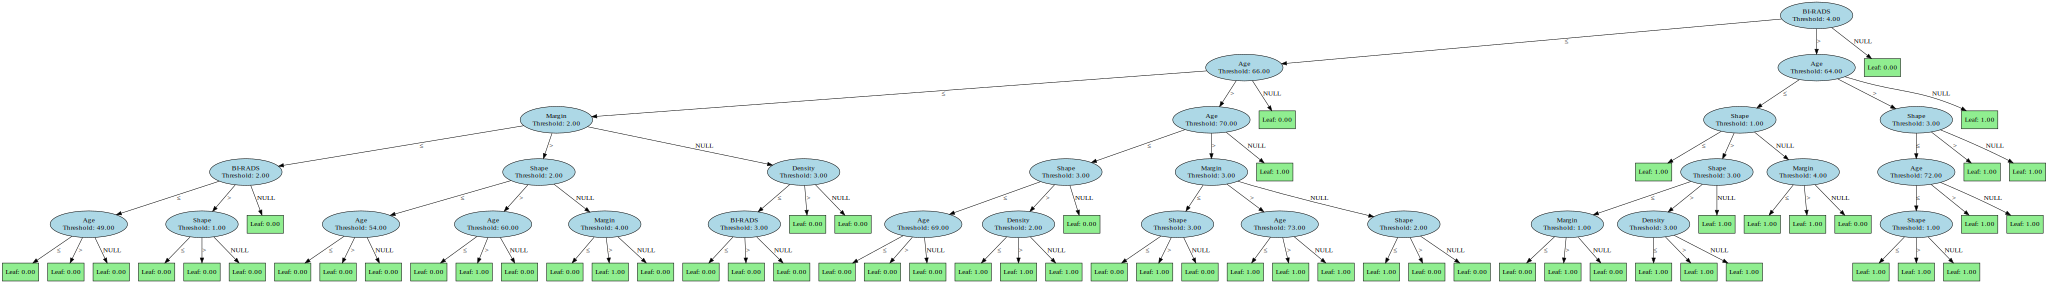

In [31]:
treeView = rf_custom.trees[1].tree
graph = visualize_tree(treeView, X_train)

graph

# DATASET IMPUTAT AMB Fillna()

In [32]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

#  Substitueix valors especials per NaN
Xdata.replace(['?', -1, 'unknown', 'Unknown', ''], np.nan, inplace=True)

#  Imputació de valors nuls amb la mitjana de cada columna numèrica
Xdata_imputed = Xdata.copy()
for col in Xdata_imputed.columns:
    if Xdata_imputed[col].dtype in ['float64', 'int64']:
        Xdata_imputed[col] = Xdata_imputed[col].fillna(Xdata_imputed[col].mean())

#  Divisió en train i test amb dades imputades
X_train, X_test, y_train, y_test = train_test_split(Xdata_imputed, ydata, test_size=0.2, random_state=42, stratify=ydata)

print("🔍 X_test shape:", X_test.shape)
print("🔍 y_test shape:", y_test.shape)


#  Entrenar el model amb Random Forest personalitzat
rf_custom = RandomForest(n_trees=25, max_depth=5, max_features=2)
rf_custom.fit(X_train, y_train)

#  Predir amb el Random Forest personalitzat
start_time = time.time()

y_pred_custom = rf_custom.predict(X_test)
time_custom = time.time() - start_time

#  Validació de resultats
print("\n Predicció del model:")
print(f"Tipus: {type(y_pred_custom)}")
print(f"Forma: {y_pred_custom.shape}")
print(f"Primers valors: {y_pred_custom[:10].values if isinstance(y_pred_custom, pd.Series) else y_pred_custom[:10]}")
print(f" Temps de predicció: {time_custom:.4f} s")

#  Avaluació amb múltiples mètriques
print("\n Mètriques de classificació:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_custom):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_custom, average='macro'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_custom, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_custom, average='macro'):.4f}")

print("\n Matriu de confusió:")
print(confusion_matrix(y_test, y_pred_custom))

print("\n Informe de classificació:")
print(classification_report(y_test, y_pred_custom))

<ipython-input-32-afad93781804>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xdata.replace(['?', -1, 'unknown', 'Unknown', ''], np.nan, inplace=True)


🔍 X_test shape: (193, 5)
🔍 y_test shape: (193, 1)

 Predicció del model:
Tipus: <class 'pandas.core.series.Series'>
Forma: (193,)
Primers valors: [1 1 0 0 1 1 1 1 1 1]
 Temps de predicció: 0.3590 s

 Mètriques de classificació:
Accuracy: 0.8446
Precision: 0.8458
Recall: 0.8477
F1 Score: 0.8445

 Matriu de confusió:
[[84 20]
 [10 79]]

 Informe de classificació:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       104
           1       0.80      0.89      0.84        89

    accuracy                           0.84       193
   macro avg       0.85      0.85      0.84       193
weighted avg       0.85      0.84      0.84       193



# CROSS VALIDATION

In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configuració de cross-validation
k = 5  # pots provar amb 5 o 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Guardem mètriques de cada fold
accuracies = []
precisions = []
recalls = []
f1s = []

for fold, (train_index, val_index) in enumerate(kf.split(Xdata)):
    print(f"\nFold {fold + 1}/{k}")

    X_train, X_val = Xdata.iloc[train_index], Xdata.iloc[val_index]
    y_train, y_val = ydata.iloc[train_index], ydata.iloc[val_index]

    # oversampling aqui

    rf_custom = RandomForest(n_trees=25, max_depth=5, max_features=2)
    rf_custom.fit(X_train, y_train)

    y_pred = rf_custom.predict(X_val)

    # Mètriques
    accuracies.append(accuracy_score(y_val, y_pred))
    precisions.append(precision_score(y_val, y_pred, average='macro'))
    recalls.append(recall_score(y_val, y_pred, average='macro'))
    f1s.append(f1_score(y_val, y_pred, average='macro'))

# Resultats mitjans
print("\n Mitjanes Cross-Validation:")
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision (macro): {np.mean(precisions):.4f}")
print(f"Recall (macro): {np.mean(recalls):.4f}")
print(f"F1 Score (macro): {np.mean(f1s):.4f}")


Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

 Mitjanes Cross-Validation:
Accuracy: 0.8429
Precision (macro): 0.8430
Recall (macro): 0.8401
F1 Score (macro): 0.8406


# XGBoost Test

In [34]:

import xgboost as xgb

# Substitueix valors especials per NaN
Xdata.replace(['?', -1, 'unknown', 'Unknown', ''], np.nan, inplace=True)
ydata = ydata.replace({2: 0, 4: 1}) #xgboost espera 0,1 ---> Pel Breast Cancer Wisconsin
# Divisió en train i test
#Amb stratify mantenim prorporcio de la clase en test i train
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata, test_size=0.2, random_state=42, stratify=ydata)
print(" X_test shape:", X_test.shape)
print(" y_test shape:", y_test.shape)

#  Entrenar el model amb XGBoost
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=20,
    max_depth=5,
    learning_rate=0.1,
    eval_metric='mlogloss',
    random_state=42
)
xgb_clf.fit(X_train, y_train)

#  Predir amb XGBoost
start_time = time.time()
y_pred_xgb = xgb_clf.predict(X_test)
time_xgb = time.time() - start_time

# Validació de resultats
print("\n Predicció amb XGBoost:")
print(f"Tipus: {type(y_pred_xgb)}")
print(f"Forma: {y_pred_xgb.shape}")
print(f"Primers valors: {y_pred_xgb[:10]}")
print(f" Temps de predicció: {time_xgb:.4f} s")

#  Avaluació amb múltiples mètriques
print("\n Mètriques de classificació:")

print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb, average='macro'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb, average='macro'):.4f}")

print("\n Matriu de confusió:")
print(confusion_matrix(y_test, y_pred_xgb))

#  Resum complet per classe
print("\n Informe de classificació:")
print(classification_report(y_test, y_pred_xgb))

 X_test shape: (193, 5)
 y_test shape: (193, 1)

 Predicció amb XGBoost:
Tipus: <class 'numpy.ndarray'>
Forma: (193,)
Primers valors: [1 1 0 0 1 1 1 1 1 1]
 Temps de predicció: 0.0050 s

 Mètriques de classificació:
Accuracy: 0.8290
Precision: 0.8288
Recall: 0.8308
F1 Score: 0.8287

 Matriu de confusió:
[[84 20]
 [13 76]]

 Informe de classificació:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       104
           1       0.79      0.85      0.82        89

    accuracy                           0.83       193
   macro avg       0.83      0.83      0.83       193
weighted avg       0.83      0.83      0.83       193



<ipython-input-34-7bdec2e862a3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xdata.replace(['?', -1, 'unknown', 'Unknown', ''], np.nan, inplace=True)


# LightGBM Test

In [35]:
import lightgbm as lgb

# Substitueix valors especials per NaN
Xdata.replace(['?', -1, 'unknown', 'Unknown', ''], np.nan, inplace=True)

# Divisió en train i test
#Amb stratify mantenim prorporcio de la clase en test i train
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata, test_size=0.2, random_state=42, stratify=ydata)
print("🔍 X_test shape:", X_test.shape)
print("🔍 y_test shape:", y_test.shape)


# Entrenar el model amb LightGBM
lgbm_clf = lgb.LGBMClassifier(
    n_estimators=20,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

lgbm_clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Predir amb LightGBM
start_time = time.time()
y_pred_lgbm = lgbm_clf.predict(X_test)
time_lgbm = time.time() - start_time

# Validació de resultats
print("\n Predicció amb LightGBM:")
print(f"Tipus: {type(y_pred_lgbm)}")
print(f"Forma: {y_pred_lgbm.shape}")
print(f"Primers valors: {y_pred_lgbm[:10]}")
print(f" Temps de predicció: {time_lgbm:.4f} s")

# Avaluació amb múltiples mètriques
print("\n Mètriques de classificació:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgbm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lgbm, average='macro'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lgbm, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lgbm, average='macro'):.4f}")

print("\n Matriu de confusió:")
print(confusion_matrix(y_test, y_pred_lgbm))

# Resum complet per classe
print("\n Informe de classificació:")
print(classification_report(y_test, y_pred_lgbm))

🔍 X_test shape: (193, 5)
🔍 y_test shape: (193, 1)
[LightGBM] [Info] Number of positive: 356, number of negative: 412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463542 -> initscore=-0.146093
[LightGBM] [Info] Start training from score -0.146093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

<ipython-input-35-abb22a66131d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xdata.replace(['?', -1, 'unknown', 'Unknown', ''], np.nan, inplace=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A